/content/drive/MyDrive/stroke classification


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [3]:
import numpy as np 
import pandas as pd 
!pip install utils 
from utils import * 
from glob import glob 
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split 
from itertools import chain
from datetime import datetime 
import statistics 
from tqdm import tqdm 
import tensorflow as tf
# DenseNet Dependencies
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, BinaryAccuracy, FalsePositives
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201, VGG16, ResNet50 
from tensorflow.keras import backend as K 
import matplotlib
from sklearn.metrics import roc_curve, auc, roc_auc_score
print("started")



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
started


In [4]:

!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/rizwanulhoqueratul/brain-mri-data?select=Brain_Data_Organised")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mennaeraky
Your Kaggle Key: ··········


100%|██████████| 60.4M/60.4M [00:04<00:00, 14.7MB/s]


In [5]:
#This code counts the number of files in two different folders using the os.walk function and the len function, and prints the results 
path, dirs, files = next(os.walk("/content/brain-mri-data/Brain_Data_Organised/Train/Stroke"))
file_count = len(files)
print('Stroke:', file_count)

path, dirs, files = next(os.walk("/content/brain-mri-data/Brain_Data_Organised/Train/Normal"))
file_count = len(files)
print('Non-Stroke:', file_count)


Stroke: 825
Non-Stroke: 1426


In [6]:
# Set the image size and batch size for the datasets.
image_size = (224, 224)
batch_size = 32
# Load the training dataset from the directory "Brain_Data_Organised/Train".
# Split the dataset into training and validation subsets using a validation split of 0.20.
# Use a seed value of 1337 for reproducibility.
# Set the image size and batch size.
train_df = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/brain-mri-data/Brain_Data_Organised/Train", 
    validation_split=0.20, 
    subset="training",
    seed=1337,
    image_size=image_size, 
    batch_size=batch_size,
)
# Load the validation dataset from the directory "Brain_Data_Organised/Train".
# Split the dataset into training and validation subsets using a validation split of 0.20.
# Use a seed value of 333 for reproducibility.
# Set the image size and batch size.
val_df = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/brain-mri-data/Brain_Data_Organised/Train", 
    validation_split=0.20, 
    subset="validation", 
    seed=333, 
    image_size=image_size, 
    batch_size=batch_size,
)
# Load the test dataset from the directory "Brain_Data_Organised/Test".
# Do not shuffle the test dataset.
# Set the image size and batch size.
test_df = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/brain-mri-data/Brain_Data_Organised/Test", 
    image_size=image_size, 
    batch_size=batch_size, 
    shuffle=False
)


Found 2251 files belonging to 2 classes.
Using 1801 files for training.
Found 2251 files belonging to 2 classes.
Using 450 files for validation.
Found 250 files belonging to 2 classes.


In [7]:
#This line  is creating a NumPy array of the true labels for the test dataset by concatenating the labels from each batch of the test_df dataset.
y_true = np.concatenate([y for x, y in test_df], axis=0)

In [8]:
# Prefetch data from the disk and load it into memory to reduce waiting time between training iterations that icrease performance
train_df = train_df.prefetch(buffer_size=32)
val_df = val_df.prefetch(buffer_size=32)

In [9]:
# Define the input image dimensions and shape.
IMG_IND = 224
IMG_SHAPE = (IMG_IND, IMG_IND, 3)
# Define the loss function to be used during training.
LOSS = BinaryCrossentropy() 
# Set the image size for pre-processing and augmentation.
IMG_SIZE = (224, 224)
# Set the random seed for reproducibility.
SEED = 2
# Set the batch size for training and evaluation.
BATCH_SIZE = 16


In [10]:
#This function definition that returns a list of Keras callbacks to be used during training of a deep learning model.
# The callbacks include ModelCheckpoint, ReduceLROnPlateau, and EarlyStopping, which are commonly used to save the best model, adjust the learning rate based on the validation loss, 
#and stop the training early if the validation loss does not improve for a certain number of epochs. The function takes a model name as an argument and returns the list of callbacks.
def get_callbacks(model_name):
    callbacks = []
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss', save_best_only=True)
    callbacks.append(checkpoint)
    anne = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=2, min_lr=0.0000001)
    callbacks.append(anne)
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(earlystop)
    return callbacks

In [11]:
#This code defines a deep learning model using the DenseNet121 architecture as a base model pre-trained on the ImageNet dataset. 
#The base model is set to be trainable, and a GlobalAveragePooling2D layer is added to reduce the number of parameters ,convert output into one row like(flatten)
# A final dense layer with a sigmoid activation function is added to make a binary classification prediction.
# The model is compiled using the Adam optimizer with a  binary cross-entropy loss. The model also uses accuracy and precision as metrics during training.

OPTIMIZER = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid', name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
#model.load_weights
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy', keras.metrics.Precision()])

29084464/29084464 [==============================] - 2s 0us/step


In [12]:
#This code prints a summary of the model architecture and its parameters, including the layers, output shape of each layer, and the number of trainable and non-trainable parameters.
# The summary also shows the total number of parameters in the model. This information can be useful for verifying the model architecture and debugging any issues related to the model parameters.
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [13]:
#This code trains the defined model using the fit() method from Keras.
#The model is trained for 50 epochs using the training data "train_df" and evaluated on the validation data "val_df".
# The callbacks returned from the get_callbacks() function are used during training to perform tasks such as saving the best model, adjusting the learning rate, and stopping the training early if necessary.
# The training history is stored in the "history" variable for future analysis and visualization.
callbacks = get_callbacks('dense121')
history = model.fit(train_df, epochs=50, validation_data=val_df, callbacks=callbacks)

Epoch 1/50
57/57 [==============================] - ETA: 0s - loss: 0.5535 - accuracy: 0.7279 - precision: 0.6385
Epoch 1: val_loss improved from inf to 4.20270, saving model to model.dense121.h5
57/57 [==============================] - 113s 504ms/step - loss: 0.5535 - accuracy: 0.7279 - precision: 0.6385 - val_loss: 4.2027 - val_accuracy: 0.4844 - val_precision: 0.4247 - lr: 0.0010
Epoch 2/50
57/57 [==============================] - ETA: 0s - loss: 0.3284 - accuracy: 0.8634 - precision: 0.8423
Epoch 2: val_loss improved from 4.20270 to 3.49903, saving model to model.dense121.h5
57/57 [==============================] - 22s 387ms/step - loss: 0.3284 - accuracy: 0.8634 - precision: 0.8423 - val_loss: 3.4990 - val_accuracy: 0.6889 - val_precision: 0.9302 - lr: 0.0010
Epoch 3/50
57/57 [==============================] - ETA: 0s - loss: 0.2577 - accuracy: 0.8823 - precision: 0.8453
Epoch 3: val_loss improved from 3.49903 to 2.48137, saving model to model.dense121.h5
57/57 [==================

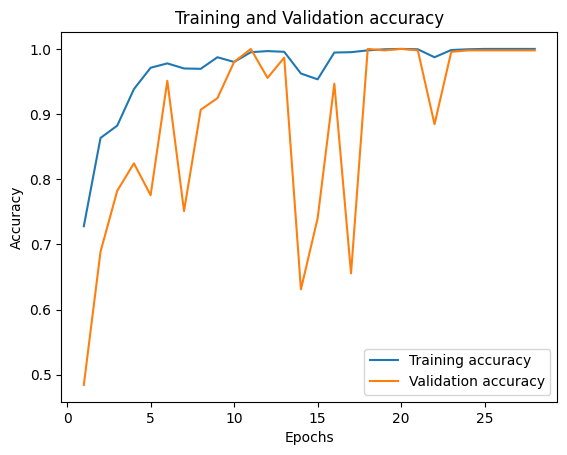

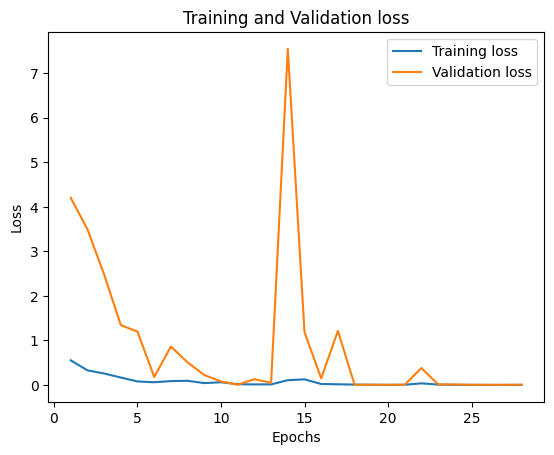

In [14]:
#This code plots the training and validation accuracy as well as the training and validation loss over the epochs
#This visualization helps to identify if the model is overfitting or underfitting by comparing the training and validation metrics.
# If the training accuracy is much higher than the validation accuracy, the model is likely overfitting, and if the validation loss is much higher than the training loss, the model is likely underfitting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
 

In [15]:
#This code loads the trained model saved as "model.dense121.h5" using the Keras load_model() method.
# This is useful for reusing a previously trained model without having to retrain it from scratch. Once loaded, the model can be used to make predictions on new data using the predict() method.
model = keras.models.load_model('model.dense121.h5')

In [16]:
results = model.evaluate(test_df, verbose=1)
#This code evaluates the performance of the loaded model on the test data 
#The evaluation returns the test loss and metrics specified during the model compilation.
#The verbose parameter set to 1 indicates that the results will be displayed
#This evaluation is useful for measuring the model's generalization performance on unseen data 

8/8 [==============================] - 5s 365ms/step - loss: 0.1054 - accuracy: 0.9600 - precision: 0.9675


In [17]:
#This code generates predictions on the test data "test_df" using the loaded model with the predict() method. The predictions are rounded to 0 or 1 using the round() method and flattened into a 1D array
y_pred = model.predict(test_df, verbose=1).round()
y_pred = y_pred.flatten()
#classification_report() method from sklearn is used to generate a report on the model's classification performance.
#The report includes metrics such as precision, recall, F1-score, and support for each class. The target_names parameter is used to specify the class labels for the report, and the digits parameter is used to set the number of digits to display for each metric.
#This report can help to evaluate the model's classification performance and identify areas for improvement.
from sklearn.metrics import classification_report
target_names = ['class non stroke', 'class stroke']
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

8/8 [==============================] - 2s 87ms/step
                  precision    recall  f1-score   support

class non stroke     0.9528    0.9680    0.9603       125
    class stroke     0.9675    0.9520    0.9597       125

        accuracy                         0.9600       250
       macro avg     0.9601    0.9600    0.9600       250
    weighted avg     0.9601    0.9600    0.9600       250



              precision    recall  f1-score   support

      Stroke     0.9528    0.9680    0.9603       125
  Non stroke     0.9675    0.9520    0.9597       125

    accuracy                         0.9600       250
   macro avg     0.9601    0.9600    0.9600       250
weighted avg     0.9601    0.9600    0.9600       250



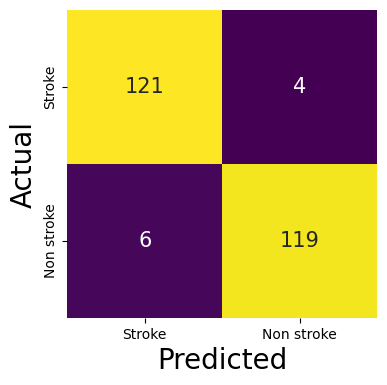

In [18]:
#This code generates a confusion matrix using the true labels "y_true" and the predicted labels "y_pred". 
#The confusion matrix is displayed as a heatmap using the seaborn library's heatmap function. The heatmap is annotated with the count of true positives, false positives, true negatives, and false negatives in each cell.
#the fmt parameter is used to format the cell values as integers. The seaborn heatmap function also allows customization of the heatmap's colors and font size
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

target_names = ['Stroke', 'Non stroke']
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)

disp = confusion_matrix(y_true, y_pred)
disp = disp.astype('int')
pd.options.display.float_format = '{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)

fig, ax = plt.subplots(figsize=(4, 4))
sns.set(font_scale=1.5) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 15}, ax=ax, cmap="viridis", fmt='g', cbar=False) # font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()


8/8 [==============================] - 1s 94ms/step
AUC score: 0.995648


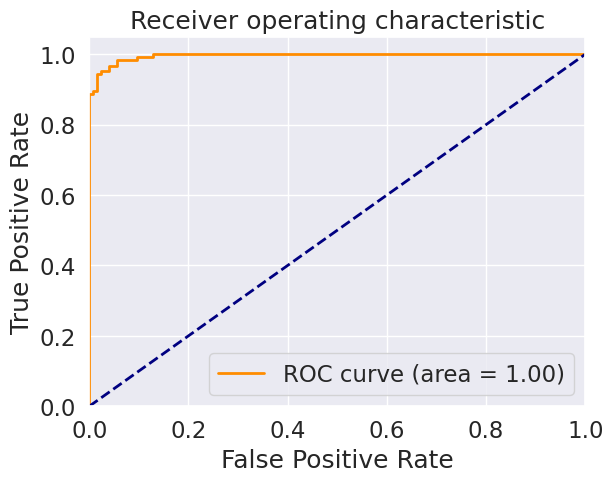

In [30]:
# Make predictions on the test dataset using the trained model
#y_pred_prob = model.predict(test_df)
y_pred_prob = model.predict(test_df)

# Calculate the AUC score
auc_score = roc_auc_score(y_true, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

print("AUC score:", auc_score)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [31]:
OPTIMIZER = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid', name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
#model.load_weights
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy', keras.metrics.Precision()])

94765736/94765736 [==============================] - 4s 0us/step


In [32]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [33]:
callbacks = get_callbacks('ResNet50')
history = model.fit(train_df, epochs=50, validation_data=val_df, callbacks=callbacks)

Epoch 1/50
57/57 [==============================] - ETA: 0s - loss: 0.7132 - accuracy: 0.6718 - precision_1: 0.5574
Epoch 1: val_loss improved from inf to 7.30111, saving model to model.ResNet50.h5
57/57 [==============================] - 69s 437ms/step - loss: 0.7132 - accuracy: 0.6718 - precision_1: 0.5574 - val_loss: 7.3011 - val_accuracy: 0.6067 - val_precision_1: 0.0000e+00 - lr: 0.0010
Epoch 2/50
57/57 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.8440 - precision_1: 0.8278
Epoch 2: val_loss did not improve from 7.30111
57/57 [==============================] - 20s 341ms/step - loss: 0.3627 - accuracy: 0.8440 - precision_1: 0.8278 - val_loss: 29.3016 - val_accuracy: 0.6067 - val_precision_1: 0.0000e+00 - lr: 0.0010
Epoch 3/50
57/57 [==============================] - ETA: 0s - loss: 0.1743 - accuracy: 0.9289 - precision_1: 0.9122
Epoch 3: val_loss improved from 7.30111 to 1.19901, saving model to model.ResNet50.h5
57/57 [==============================] - 2

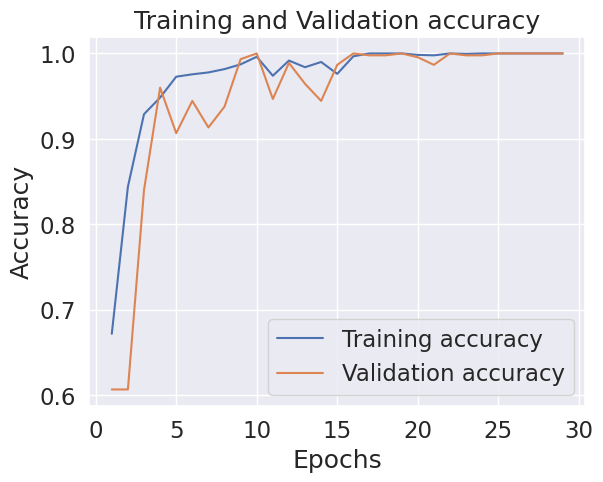

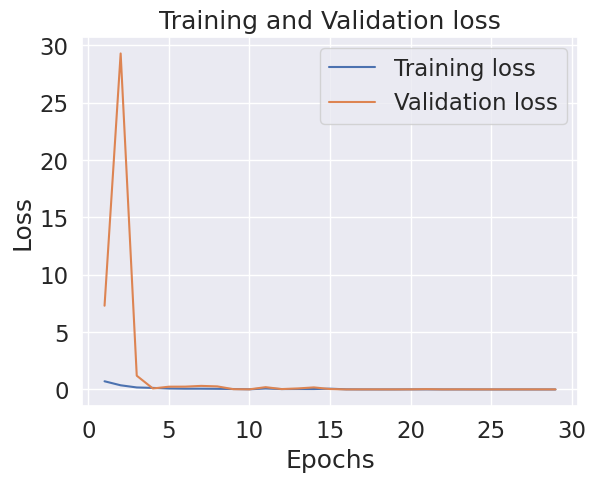

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
 

              precision    recall  f1-score   support

      Stroke     0.9528    0.9680    0.9603       125
  Non stroke     0.9675    0.9520    0.9597       125

    accuracy                         0.9600       250
   macro avg     0.9601    0.9600    0.9600       250
weighted avg     0.9601    0.9600    0.9600       250



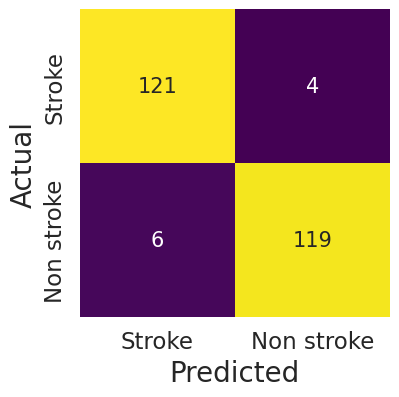

In [35]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

target_names = ['Stroke', 'Non stroke']
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)

disp = confusion_matrix(y_true, y_pred)
disp = disp.astype('int')
pd.options.display.float_format = '{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)

fig, ax = plt.subplots(figsize=(4, 4))
sns.set(font_scale=1.5) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 15}, ax=ax, cmap="viridis", fmt='g', cbar=False) # font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()

8/8 [==============================] - 4s 223ms/step
AUC score: 0.9932799999999999


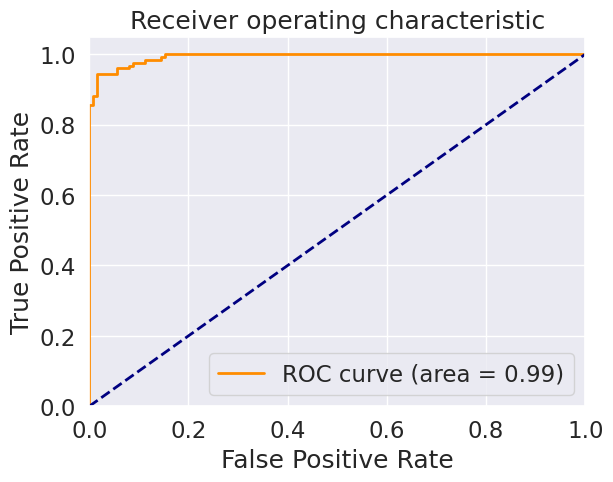

In [36]:
# Make predictions on the test dataset using the trained model

y_pred_prob = model.predict(test_df)

# Calculate the AUC score
auc_score = roc_auc_score(y_true, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

print("AUC score:", auc_score)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [37]:
OPTIMIZER = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid', name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
#model.load_weights
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy', keras.metrics.Precision()])

17225924/17225924 [==============================] - 1s 0us/step


In [38]:
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [39]:
callbacks = get_callbacks('MobileNet')
history = model.fit(train_df, epochs=50, validation_data=val_df, callbacks=callbacks)

Epoch 1/50
57/57 [==============================] - ETA: 0s - loss: 0.5693 - accuracy: 0.7674 - precision_2: 0.6892
Epoch 1: val_loss improved from inf to 2.09318, saving model to model.MobileNet.h5
57/57 [==============================] - 27s 168ms/step - loss: 0.5693 - accuracy: 0.7674 - precision_2: 0.6892 - val_loss: 2.0932 - val_accuracy: 0.6089 - val_precision_2: 1.0000 - lr: 0.0010
Epoch 2/50
56/57 [============================>.] - ETA: 0s - loss: 0.2092 - accuracy: 0.9174 - precision_2: 0.8911
Epoch 2: val_loss improved from 2.09318 to 0.88900, saving model to model.MobileNet.h5
57/57 [==============================] - 8s 136ms/step - loss: 0.2082 - accuracy: 0.9178 - precision_2: 0.8916 - val_loss: 0.8890 - val_accuracy: 0.7800 - val_precision_2: 0.9149 - lr: 0.0010
Epoch 3/50
56/57 [============================>.] - ETA: 0s - loss: 0.1154 - accuracy: 0.9598 - precision_2: 0.9434
Epoch 3: val_loss improved from 0.88900 to 0.26947, saving model to model.MobileNet.h5
57/57 [===

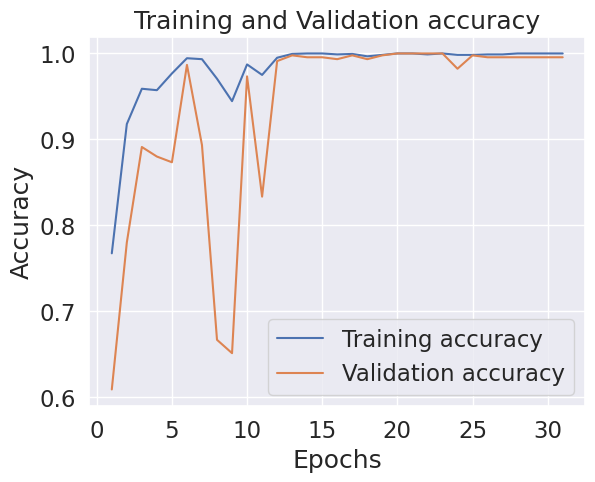

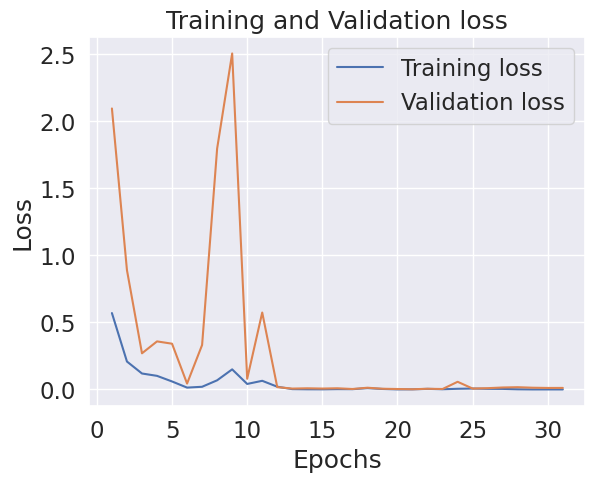

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

              precision    recall  f1-score   support

      Stroke     0.9528    0.9680    0.9603       125
  Non stroke     0.9675    0.9520    0.9597       125

    accuracy                         0.9600       250
   macro avg     0.9601    0.9600    0.9600       250
weighted avg     0.9601    0.9600    0.9600       250



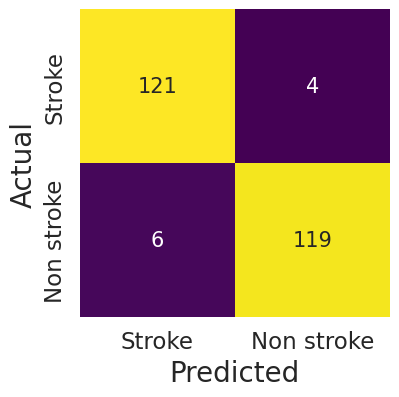

In [41]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

target_names = ['Stroke', 'Non stroke']
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)

disp = confusion_matrix(y_true, y_pred)
disp = disp.astype('int')
pd.options.display.float_format = '{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)

fig, ax = plt.subplots(figsize=(4, 4))
sns.set(font_scale=1.5) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 15}, ax=ax, cmap="viridis", fmt='g', cbar=False) # font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()

8/8 [==============================] - 1s 95ms/step
AUC score: 0.948992


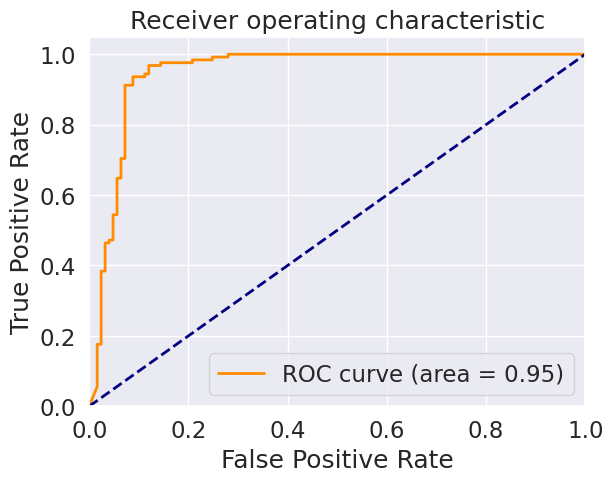

In [42]:
# Make predictions on the test dataset using the trained model

y_pred_prob = model.predict(test_df)

# Calculate the AUC score
auc_score = roc_auc_score(y_true, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

print("AUC score:", auc_score)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [43]:
OPTIMIZER = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
tf.keras.applications.Xception(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid', name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
#model.load_weights
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy', keras.metrics.Precision()])

83683744/83683744 [==============================] - 4s 0us/step


In [44]:
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [45]:
callbacks = get_callbacks('Xception')
history = model.fit(train_df, epochs=50, validation_data=val_df, callbacks=callbacks)

Epoch 1/50
57/57 [==============================] - ETA: 0s - loss: 0.0893 - accuracy: 0.9661 - precision_3: 0.9527
Epoch 1: val_loss improved from inf to 0.39086, saving model to model.Xception.h5
57/57 [==============================] - 24s 139ms/step - loss: 0.0893 - accuracy: 0.9661 - precision_3: 0.9527 - val_loss: 0.3909 - val_accuracy: 0.8733 - val_precision_3: 0.7752 - lr: 0.0010
Epoch 2/50
56/57 [============================>.] - ETA: 0s - loss: 0.0503 - accuracy: 0.9833 - precision_3: 0.9800
Epoch 2: val_loss did not improve from 0.39086
57/57 [==============================] - 7s 125ms/step - loss: 0.0501 - accuracy: 0.9833 - precision_3: 0.9800 - val_loss: 0.9252 - val_accuracy: 0.8178 - val_precision_3: 1.0000 - lr: 0.0010
Epoch 3/50
56/57 [============================>.] - ETA: 0s - loss: 0.0977 - accuracy: 0.9710 - precision_3: 0.9658
Epoch 3: val_loss improved from 0.39086 to 0.26663, saving model to model.Xception.h5
57/57 [==============================] - 8s 133ms/st

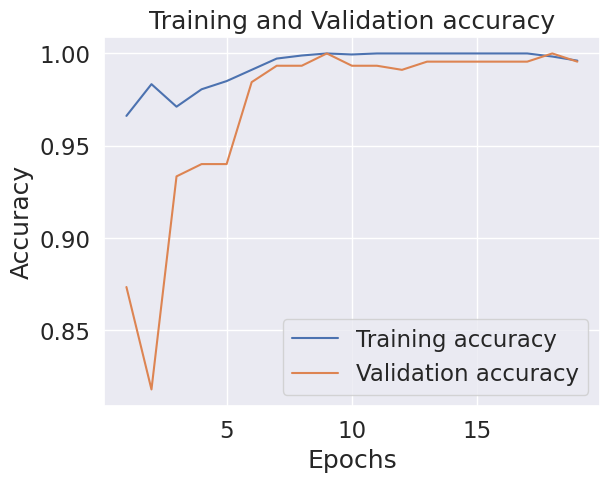

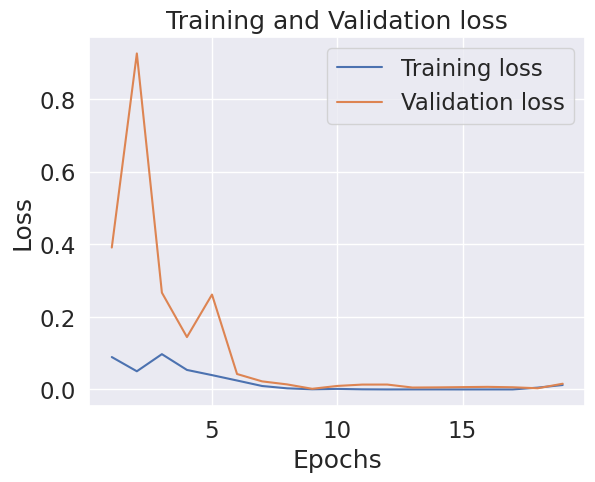

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

              precision    recall  f1-score   support

      Stroke     0.9528    0.9680    0.9603       125
  Non stroke     0.9675    0.9520    0.9597       125

    accuracy                         0.9600       250
   macro avg     0.9601    0.9600    0.9600       250
weighted avg     0.9601    0.9600    0.9600       250



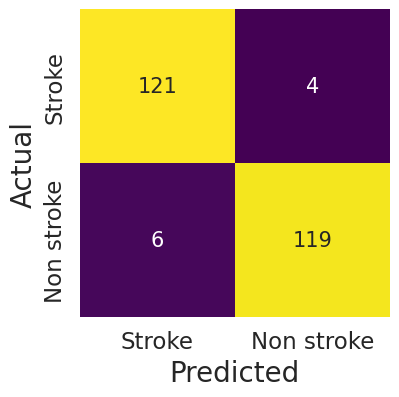

In [47]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

target_names = ['Stroke', 'Non stroke']
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)

disp = confusion_matrix(y_true, y_pred)
disp = disp.astype('int')
pd.options.display.float_format = '{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)

fig, ax = plt.subplots(figsize=(4, 4))
sns.set(font_scale=1.5) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 15}, ax=ax, cmap="viridis", fmt='g', cbar=False) # font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()

8/8 [==============================] - 1s 56ms/step
AUC score: 0.9726079999999999


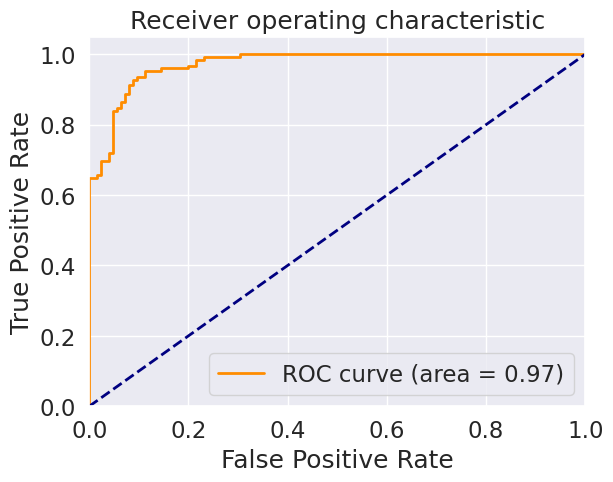

In [48]:
# Make predictions on the test dataset using the trained model

y_pred_prob = model.predict(test_df)

# Calculate the AUC score
auc_score = roc_auc_score(y_true, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

print("AUC score:", auc_score)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [49]:
OPTIMIZER = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
tf.keras.applications.VGG16(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid', name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
#model.load_weights
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy', keras.metrics.Precision()])

58889256/58889256 [==============================] - 3s 0us/step


In [50]:
print(model.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [51]:
callbacks = get_callbacks('VGG16')
history = model.fit(train_df, epochs=50, validation_data=val_df, callbacks=callbacks)

Epoch 1/50
56/57 [============================>.] - ETA: 0s - loss: 0.0498 - accuracy: 0.9777 - precision_4: 0.9554
Epoch 1: val_loss improved from inf to 0.04801, saving model to model.VGG16.h5
57/57 [==============================] - 27s 169ms/step - loss: 0.0497 - accuracy: 0.9778 - precision_4: 0.9555 - val_loss: 0.0480 - val_accuracy: 0.9889 - val_precision_4: 1.0000 - lr: 0.0010
Epoch 2/50
57/57 [==============================] - ETA: 0s - loss: 0.0454 - accuracy: 0.9833 - precision_4: 0.9771
Epoch 2: val_loss did not improve from 0.04801
57/57 [==============================] - 8s 125ms/step - loss: 0.0454 - accuracy: 0.9833 - precision_4: 0.9771 - val_loss: 2.1354 - val_accuracy: 0.7622 - val_precision_4: 0.6232 - lr: 0.0010
Epoch 3/50
56/57 [============================>.] - ETA: 0s - loss: 0.0641 - accuracy: 0.9810 - precision_4: 0.9724
Epoch 3: val_loss did not improve from 0.04801
57/57 [==============================] - 8s 129ms/step - loss: 0.0640 - accuracy: 0.9811 - pre

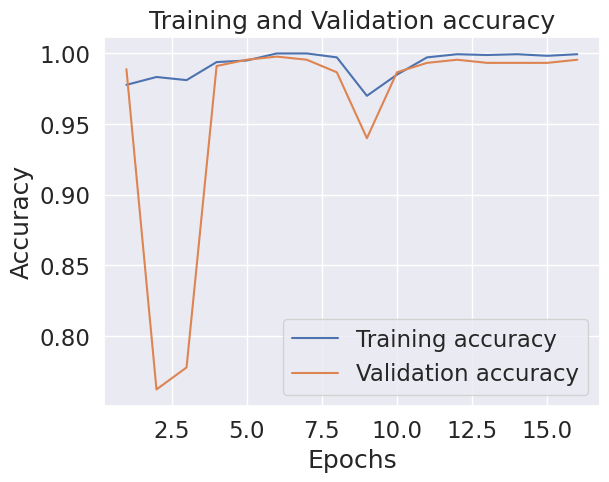

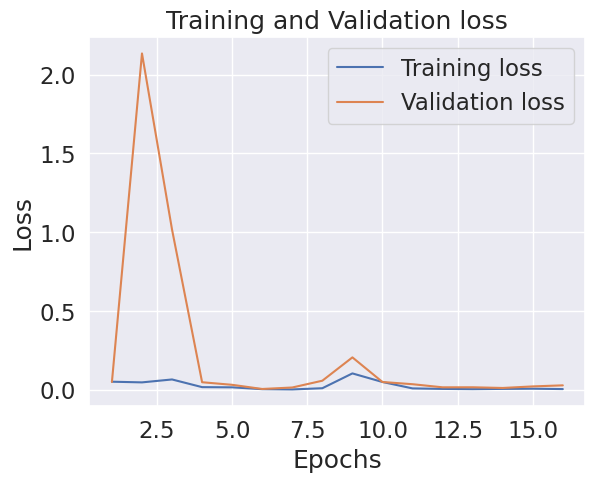

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

              precision    recall  f1-score   support

      Stroke     0.9528    0.9680    0.9603       125
  Non stroke     0.9675    0.9520    0.9597       125

    accuracy                         0.9600       250
   macro avg     0.9601    0.9600    0.9600       250
weighted avg     0.9601    0.9600    0.9600       250



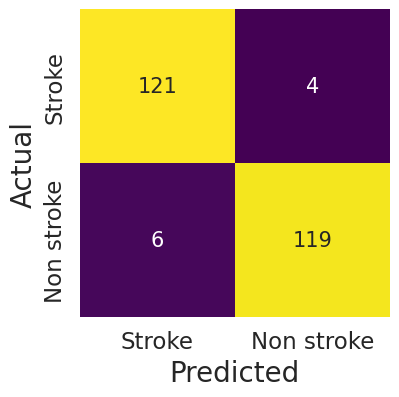

In [53]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

target_names = ['Stroke', 'Non stroke']
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)

disp = confusion_matrix(y_true, y_pred)
disp = disp.astype('int')
pd.options.display.float_format = '{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)

fig, ax = plt.subplots(figsize=(4, 4))
sns.set(font_scale=1.5) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 15}, ax=ax, cmap="viridis", fmt='g', cbar=False) # font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()

8/8 [==============================] - 1s 56ms/step
AUC score: 0.972288


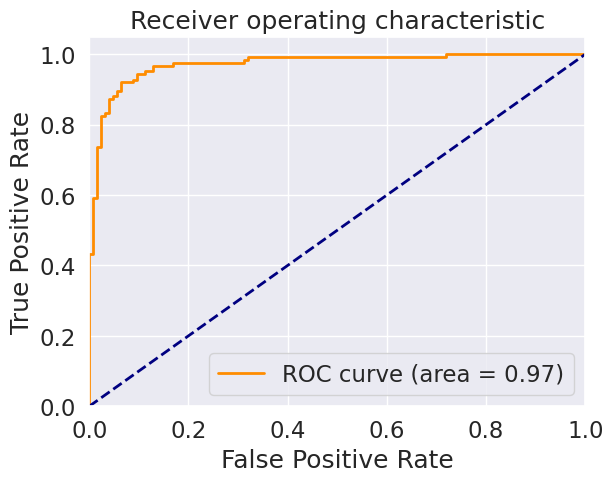

In [54]:
# Make predictions on the test dataset using the trained model

y_pred_prob = model.predict(test_df)

# Calculate the AUC score
auc_score = roc_auc_score(y_true, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

print("AUC score:", auc_score)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [55]:
OPTIMIZER = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
tf.keras.applications.EfficientNetB1(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid', name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
#model.load_weights
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy', keras.metrics.Precision()])

27018416/27018416 [==============================] - 2s 0us/step


In [56]:
print(model.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [57]:
callbacks = get_callbacks('EfficientNetB1')
history = model.fit(train_df, epochs=50, validation_data=val_df, callbacks=callbacks)

Epoch 1/50
56/57 [============================>.] - ETA: 0s - loss: 0.0430 - accuracy: 0.9821 - precision_5: 0.9640
Epoch 1: val_loss improved from inf to 0.01654, saving model to model.EfficientNetB1.h5
57/57 [==============================] - 26s 172ms/step - loss: 0.0427 - accuracy: 0.9822 - precision_5: 0.9642 - val_loss: 0.0165 - val_accuracy: 0.9956 - val_precision_5: 0.9888 - lr: 0.0010
Epoch 2/50
57/57 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9856 - precision_5: 0.9816
Epoch 2: val_loss did not improve from 0.01654
57/57 [==============================] - 8s 130ms/step - loss: 0.0443 - accuracy: 0.9856 - precision_5: 0.9816 - val_loss: 0.2321 - val_accuracy: 0.9333 - val_precision_5: 0.8551 - lr: 0.0010
Epoch 3/50
57/57 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9972 - precision_5: 0.9954
Epoch 3: val_loss did not improve from 0.01654
57/57 [==============================] - 8s 136ms/step - loss: 0.0113 - accuracy: 0.9

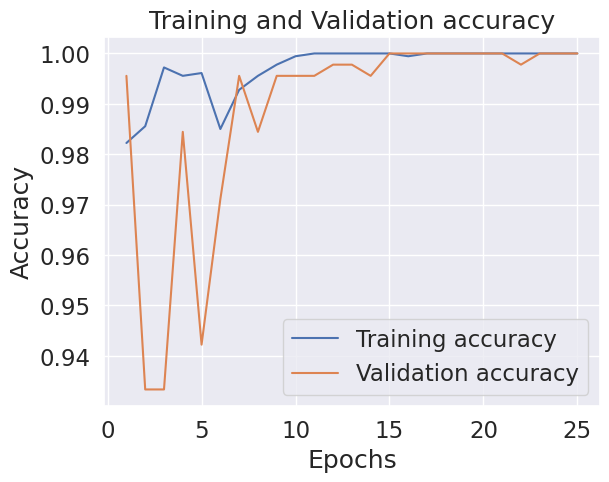

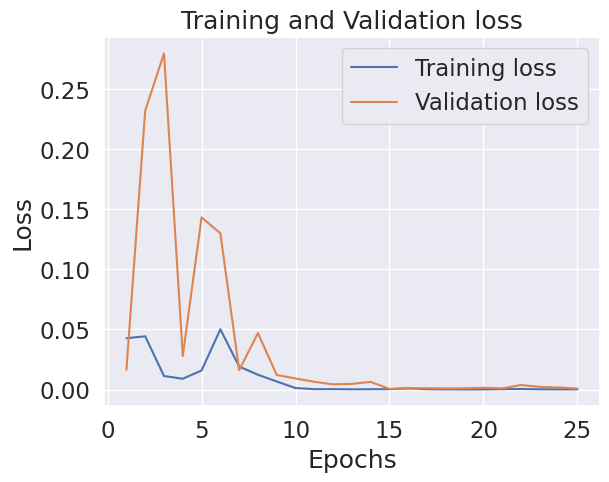

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

              precision    recall  f1-score   support

      Stroke     0.9528    0.9680    0.9603       125
  Non stroke     0.9675    0.9520    0.9597       125

    accuracy                         0.9600       250
   macro avg     0.9601    0.9600    0.9600       250
weighted avg     0.9601    0.9600    0.9600       250



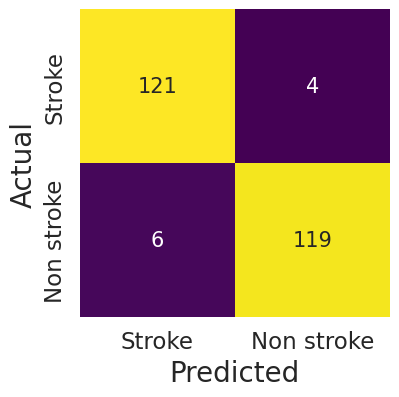

In [59]:
 from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

target_names = ['Stroke', 'Non stroke']
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)

disp = confusion_matrix(y_true, y_pred)
disp = disp.astype('int')
pd.options.display.float_format = '{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)

fig, ax = plt.subplots(figsize=(4, 4))
sns.set(font_scale=1.5) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 15}, ax=ax, cmap="viridis", fmt='g', cbar=False) # font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()

8/8 [==============================] - 1s 56ms/step
AUC score: 0.972608


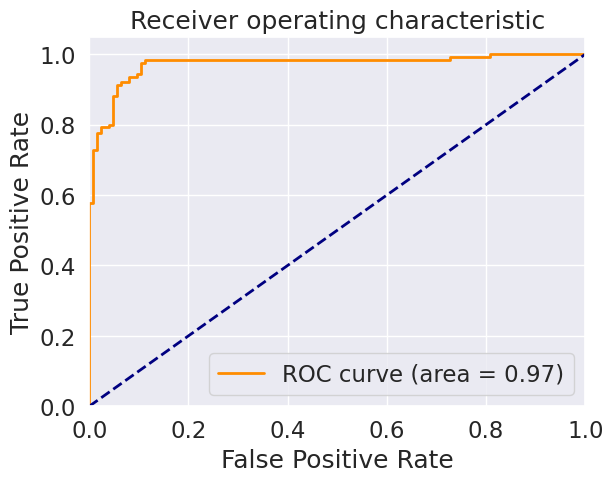

In [60]:
# Make predictions on the test dataset using the trained model

y_pred_prob = model.predict(test_df)

# Calculate the AUC score
auc_score = roc_auc_score(y_true, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

print("AUC score:", auc_score)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show() 